# Data processing

In [22]:

#path = "C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
#path = '/Users/juanbeta/My Drive/Research/MOPTA/MOPTA-23/Data/'

vehicles = pd.read_csv(path+'MOPTA2023_car_locations.csv', sep = ',', header = None)
vehicles = vehicles.append([vehicles]*9,ignore_index=True)

stations = pd.read_csv(path+"fuel_stations.csv")

northern = (-79.761960, 42.269385)
southern = (-76.9909,39.7198)
western = (-80.519400, 40.639400)
eastern = (-74.689603, 41.363559)

stations_loc = stations[["Longitude","Latitude"]]
stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53

stations = stations_loc[(stations_loc["Longitude"] <= 290) & (stations_loc["Latitude"] <= 150)]
stations.rename(columns={"Longitude": 0, "Latitude":1}, inplace=True)

C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_9144\1863623359.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vehicles = vehicles.append([vehicles]*9,ignore_index=True)
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_9144\1863623359.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_9144\1863623359.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [23]:
loc, scale, min_v, max_v= 100, 50, 20, 250
a, b = (min_v - loc) / scale, (max_v - loc) / scale

def generate_distances():
    distances = dict()
    for i in vehicles.index:
        for st in stations.index:    
            distances[st,i] = euclidean([vehicles[0][i], vehicles[1][i]],[stations[0][st], stations[1][st]])
    return distances

def generate_feasible_instance(distances):
    flag = True
    ii = -1
    while flag:
        ii += 1
        flag = False
        total_v = 0
        ranges, realized = list(), list()

        for i in vehicles.index:
            feas = False
            rr = truncnorm.rvs(a = a, b = b, loc = loc, scale = scale, size = 1)
            ranges.append(rr[0])
            prob = np.exp(-0.012**2*(rr-20)**2)
            realization = random.choice([True,False], p = [prob[0], 1-prob[0]])
            realized.append(realization)
            if realization == True:
                total_v += 1
                for st in stations.index:    
                    if distances[st,i] <= rr:
                        feas = True

                if not feas:
                    flag = True
                    print(f'\tTry n. {ii} failed at vehicle {i}')
                    break
    
    print(f'\tTry n. {ii} succesfull - {total_v} realized EV')

    return ranges, realized, total_v

In [4]:
random.seed(0)

total_ev = dict()

realizations = list()
for instance in range(25):
    print(f'\nGENERATING INSTANCE N.o {instance}')
    ranges, realized, total_v = generate_feasible_instance(d_matrix)

    realizations.append((ranges,realized))

    vehicles[f'ranges {instance}'] = ranges
    vehicles[f'realized {instance}'] = realized

    total_ev[instance] = total_v

data0 = [total_ev, realizations]
data = [total_ev, vehicles]

a_file = open(path + f'feasible instances0', "wb")
pickle.dump(data0, a_file)
a_file.close()


a_file = open(path + f'feasible instances', "wb")
pickle.dump(data, a_file)
a_file.close()


GENERATING INSTANCE N.o 0


NameError: name 'd_matrix' is not defined

In [15]:
for sc in range(25):
    data[f"reachable stations {sc}"] = [0 for i in data.index]
    data[f"reachable stations {sc}"] = data[f"reachable stations {sc}"].astype("object")
    for i in data.index:
        data.at[i,f"reachable stations {sc}"] = [st for st in stations.index if data.loc[i,f"ranges {sc}"]>=d_matrix[st,i]] if data.loc[i,f"realized {sc}"] else ["NA"]


for mi in [10,15,25,40]:
    for sc in range(25):
        data[f"reachable stations {mi} miles {sc}"] = [0 for i in data.index]
        data[f"reachable stations {mi} miles {sc}"] = data[f"reachable stations {mi} miles {sc}"].astype("object")
        for i in data.index:
            data.at[i,f"reachable stations {mi} miles {sc}"] = [st for st in stations.index if data.loc[i,f"ranges {sc}"]>=d_matrix[st,i] and d_matrix[st,i]<=mi] if data.loc[i,f"realized {sc}"] else ["NA"]

for mi in [10,15,25,40]:
    for sc in range(25):
        data[f"closest {mi} stations {sc}"] = [0 for i in data.index]
        data[f"closest {mi} stations {sc}"] = data[f"closest {mi} stations {sc}"].astype("object")
        for i in data.index:
            if data.loc[i,f"realized {sc}"]:
                feas_st = data.at[i,f"reachable stations {sc}"]
                dist = {st:d_matrix[st,i] for st in feas_st}
                sort_dist = [st for st in sorted(dist, key=dist.get, reverse=False)[:min(mi,len(feas_st))]]
                data.at[i,f"closest {mi} stations {sc}"] = sort_dist
            else:
                data.at[i,f"closest {mi} stations {sc}"] = ["NA"]


C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_8448\4125937588.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"reachable stations {mi} miles {sc}"] = [0 for i in data.index]
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_8448\4125937588.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"reachable stations {mi} miles {sc}"] = [0 for i in data.index]
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_8448\4125937588.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

# Imports

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
from gurobipy import *
from scipy.spatial.distance import cdist, euclidean
from scipy.stats import truncnorm
from scipy.sparse import csr_matrix
from time import time
import networkx as nx

import pickle

path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"

# Open file

In [27]:
d_matrix = generate_distances()

In [41]:
def generate_at(r,d,K_s,S,driving_speed,charging_rate):
    p = {(k,s):250-(r[k]-d[s,k]) for s in S for k in K_s[s]}
    t = {(k,s):p[k,s]/charging_rate  for s in S for k in K_s[s]}
    a = {(k,s):d[s,k]/driving_speed for s in S for k in K_s[s]}

    return a,t

S = list(stations.index)

file = open(path + f'feasible instances', 'rb')
data = pickle.load(file)
data = data[1]
file.close()
for sc in range(25):
    r = data[ data[f"realized {sc}"] == True ]
    r = dict(r.loc[:,[f"ranges {sc}"]].squeeze())
    print(len(r))

    file = open(path + f'/K_s/Ks_sc{sc}', 'rb')
    K_s = pickle.load(file)
    file.close()

    a,t = generate_at(r,d_matrix,K_s,S,75,75*12/7)
    file = open(path + f'/a t/at_{sc}', 'wb')
    pickle.dump((a,t), file)
    file.close()


4590
4527
4471
4551
4474
4498
4628
4565
4633
4576
4544
4472
4527
4431
4541
4491
4469
4530
4443
4559
4588
4516
4564
4559
4548


In [44]:
file = open(path + f'/a t/at_1', 'rb')
a,t = pickle.load(file)
file.close()

In [54]:
file = open(path + f'S', 'wb')
pickle.dump(S,file)
file.close()

In [40]:
(1283,1) in d_matrix.keys()

False

In [33]:
stations.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259],
           dtype='int64', length=1212)

In [5]:
file = open(path + f'feasible scenarios complete', 'rb')
data = pickle.load(file)
file.close()

C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_18200\2051813761.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{sc}" for sc in range(25)])


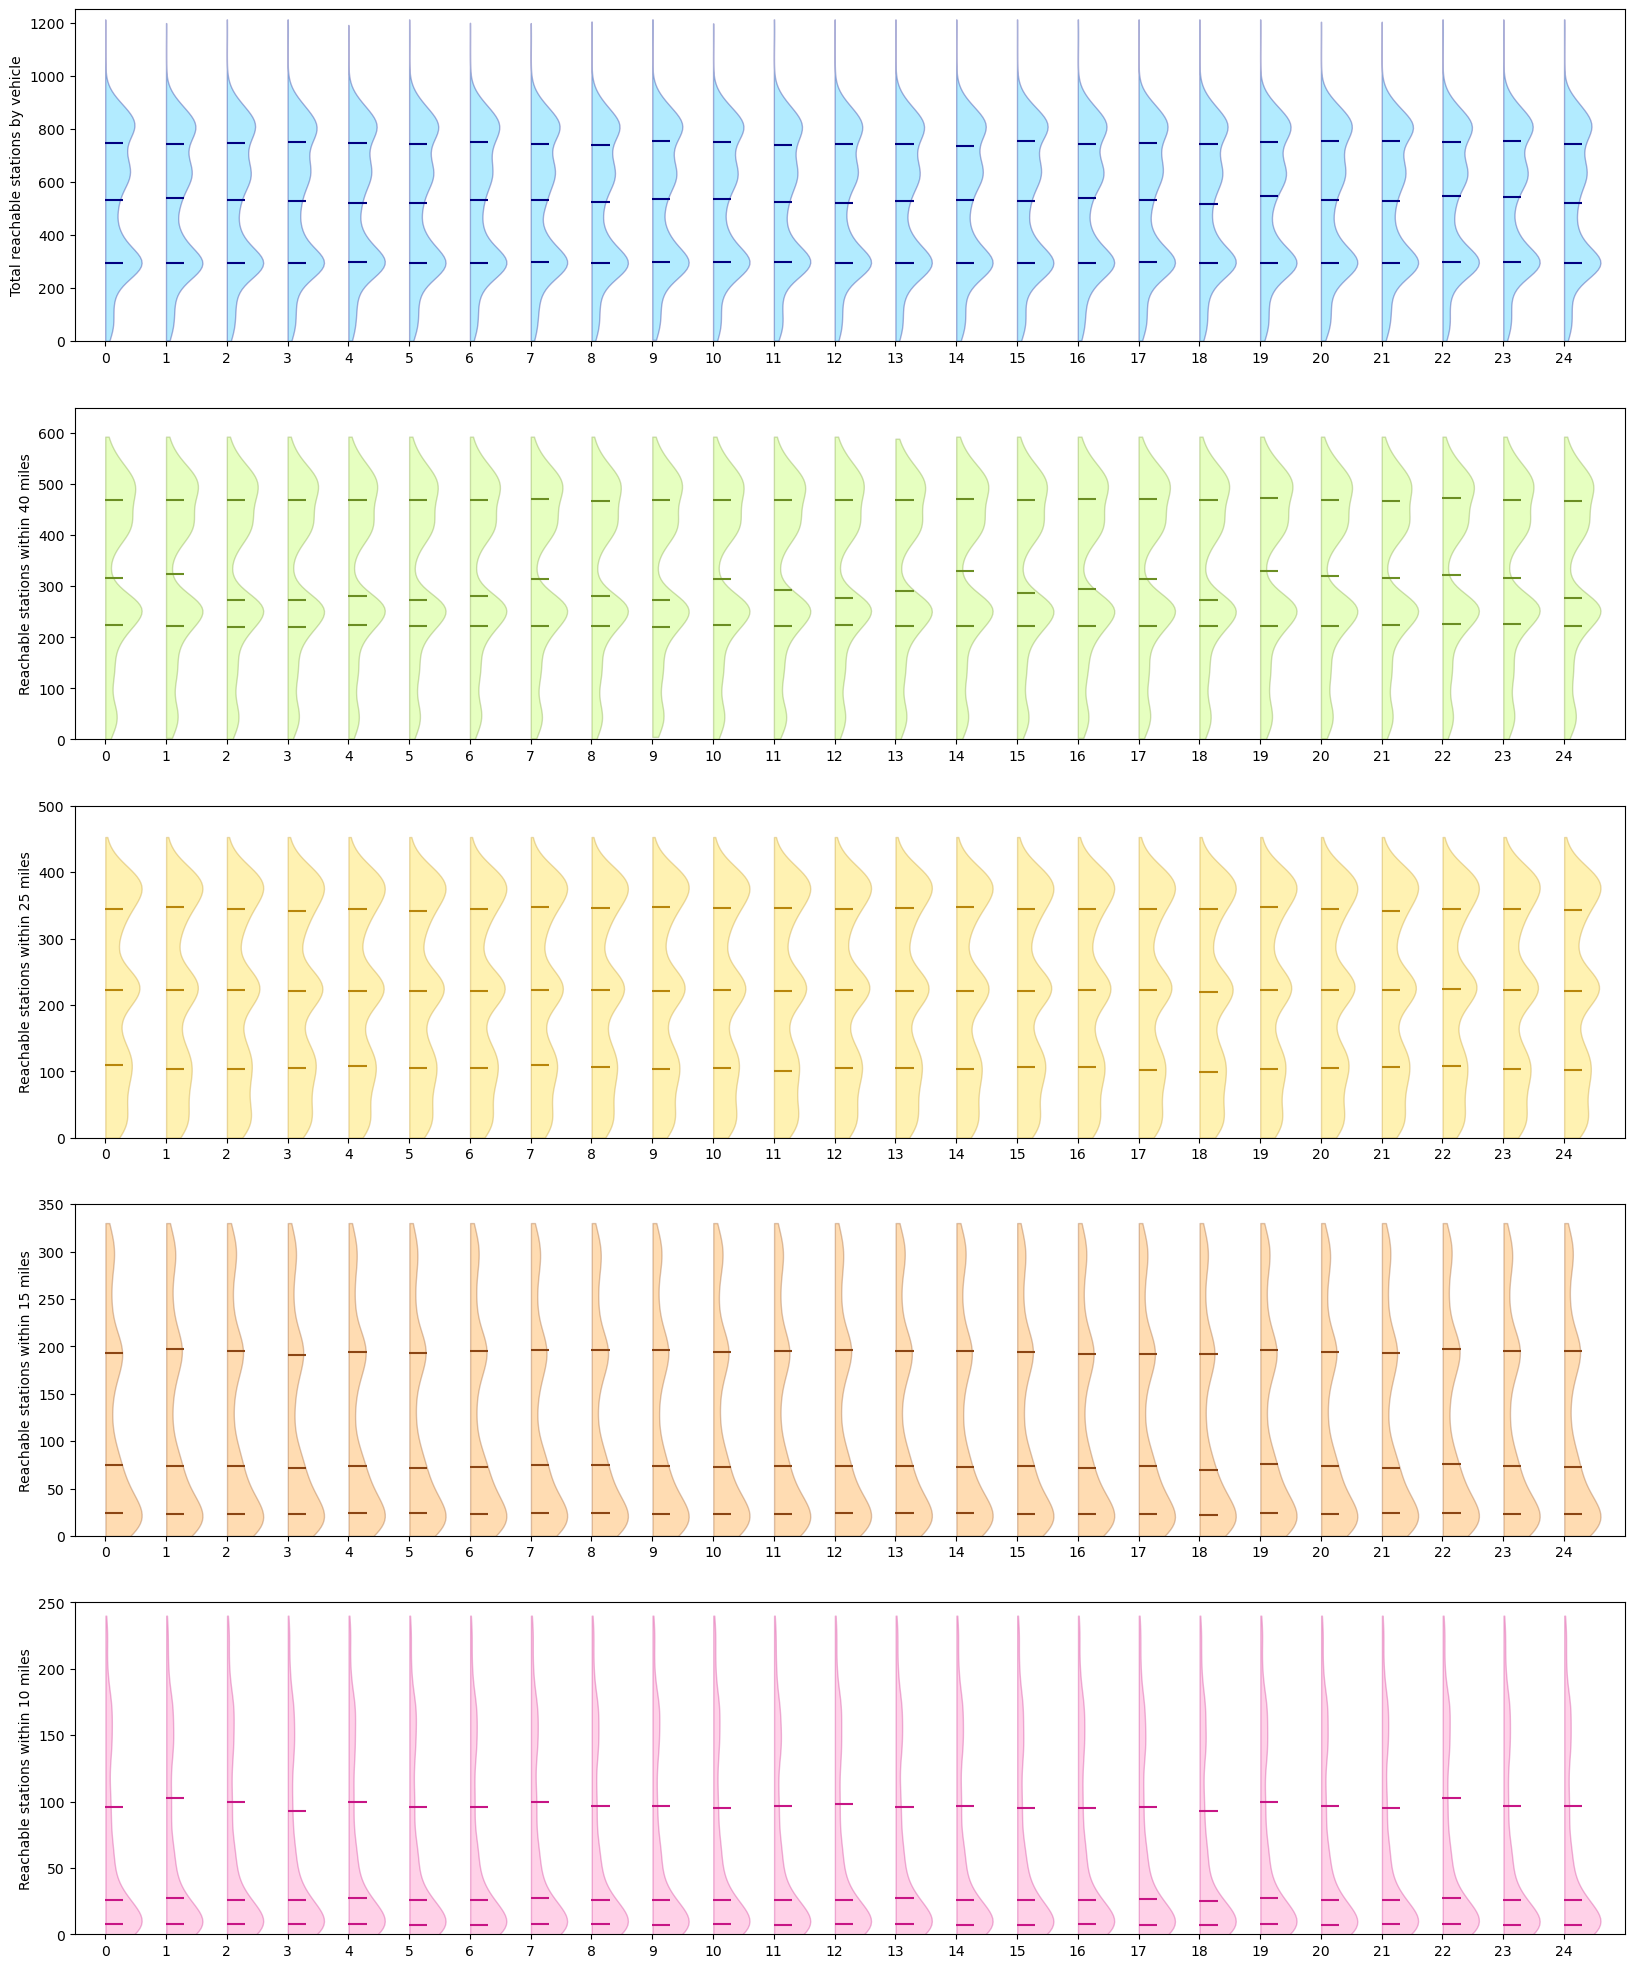

In [6]:
fig, axes = plt.subplots(nrows=5,ncols=1,figsize=(20,25))



def violin_plots(ax,col,mi=None):
    
    cols = {0:["deepskyblue","navy"],1:["greenyellow","olivedrab"],2:["gold","darkgoldenrod"],3:["darkorange","saddlebrown"],4:["hotpink","mediumvioletred"]}

    violins = {}
    for sc in range(25):

        if mi is None: s = f"reachable stations {sc}"
        else: s = f"reachable stations {mi} miles {sc}"

        sts = [len(data.at[i,s]) for i in data.index if data.at[i,s] != ["NA"]]
        violins[sc] = ax.violinplot(dataset=sts,positions=[sc],quantiles=[0.25,0.5,0.75],widths=[1.2],showextrema=False)
    ax.set_xticklabels([f"{sc}" for sc in range(25)])
    if mi is None:
        ax.set_ylabel("Total reachable stations by vehicle")
    else:
        ax.set_ylabel(f"Reachable stations within {mi} miles")

    for vi in violins:
        violins[vi]["bodies"][0].set_facecolor(cols[col][0])
        violins[vi]["bodies"][0].set_edgecolor(cols[col][1])
        violins[vi]["cquantiles"].set_edgecolor(cols[col][1])
        for b in violins[vi]["bodies"]:
            m = np.mean(b.get_paths()[0].vertices[:,0])
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        for i in range(3):
            m = np.mean(violins[vi]["cquantiles"].get_paths()[i].vertices[:,0])
            violins[vi]["cquantiles"].get_paths()[i].vertices[:, 0] = np.clip(violins[vi]["cquantiles"].get_paths()[i].vertices[:, 0], m, np.inf)

    return ax


mis = [None,40,25,15,10]; maxs = [1250,650,500,350,250]
for i in range(5):
    axes[i] = violin_plots(axes[i],i,mis[i])
    axes[i].set_xlim(-0.5,25); axes[i].set_xticks(range(25))
    axes[i].set_ylim(0,maxs[i])



In [6]:
for mi in [10,15,25,40]:
    for sc in range(25):
        stations[f"K {mi} sc {sc}"] = [0 for i in stations.index]
        stations[f"K {mi} sc {sc}"] = stations[f"K {mi} sc {sc}"].astype("object")
        for st in stations.index:
            feas_vehic = [i for i in data.index if st in data.at[i,f"closest {mi} stations {sc}"]]
            stations.at[st,f"K {mi} sc {sc}"] = feas_vehic

C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_17144\3845083905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations[f"K {mi} sc {sc}"] = [0 for i in stations.index]
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_17144\3845083905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations[f"K {mi} sc {sc}"] = stations[f"K {mi} sc {sc}"].astype("object")
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_17144\3845083905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [9]:
file = open(path + f'stations info', 'rb')
stations = pickle.load(file)
file.close()

C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_18200\3952370929.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{sc}" for sc in range(25)])


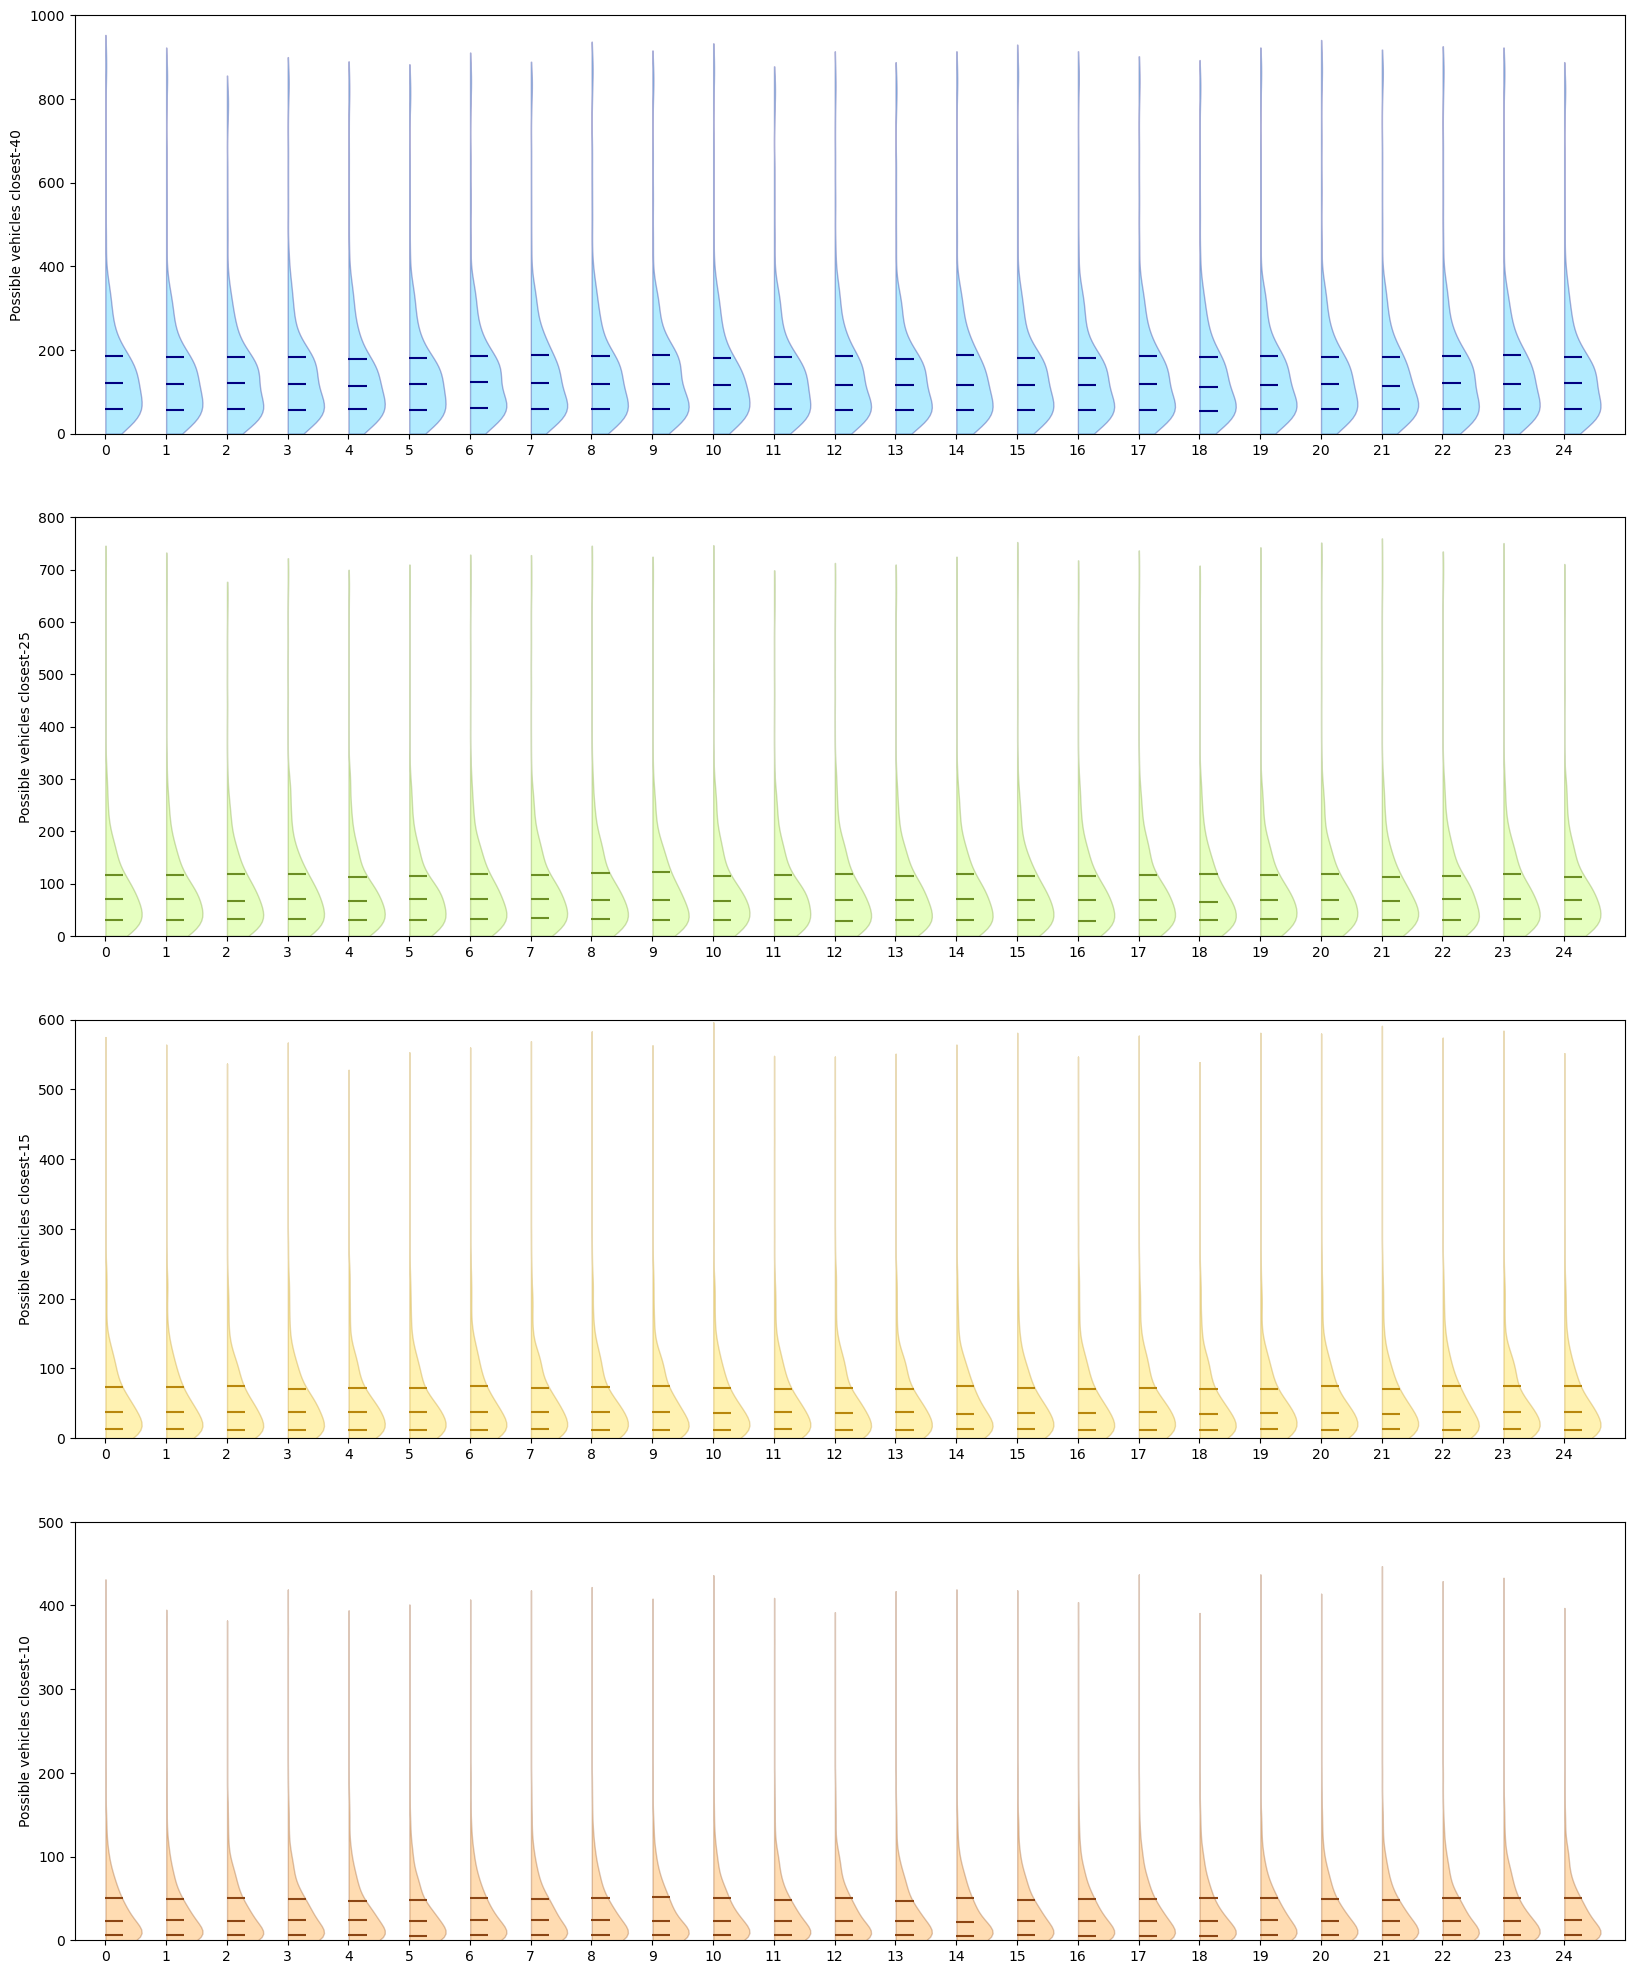

In [10]:
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(20,25))

def violin_plots_stations(ax,col,mi=None):
    
    
    cols = {0:["deepskyblue","navy"],1:["greenyellow","olivedrab"],2:["gold","darkgoldenrod"],3:["darkorange","saddlebrown"],4:["hotpink","mediumvioletred"]}

    violins = {}
    for sc in range(25):

        s = f"K {mi} sc {sc}"
        sts = [len(stations.at[st,s]) for st in stations.index if stations.at[st,s]!=0]
        violins[sc] = ax.violinplot(dataset=sts,positions=[sc],quantiles=[0.25,0.5,0.75],widths=[1.2],showextrema=False)

    ax.set_xticklabels([f"{sc}" for sc in range(25)])
    if mi is None:
        ax.set_ylabel("Total reachable stations by vehicle")
    else:
        ax.set_ylabel(f"Possible vehicles closest-{mi}")

    for vi in violins:
        violins[vi]["bodies"][0].set_facecolor(cols[col][0])
        violins[vi]["bodies"][0].set_edgecolor(cols[col][1])
        violins[vi]["cquantiles"].set_edgecolor(cols[col][1])
        for b in violins[vi]["bodies"]:
            m = np.mean(b.get_paths()[0].vertices[:,0])
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        for i in range(3):
            m = np.mean(violins[vi]["cquantiles"].get_paths()[i].vertices[:,0])
            violins[vi]["cquantiles"].get_paths()[i].vertices[:, 0] = np.clip(violins[vi]["cquantiles"].get_paths()[i].vertices[:, 0], m, np.inf)

    return ax

mis = [40,25,15,10]; maxs = [1000,800,600,500]
for i in range(4):
    axes[i] = violin_plots_stations(axes[i],i,mis[i])
    axes[i].set_xlim(-0.5,25); axes[i].set_xticks(range(25))
    axes[i].set_ylim(0,maxs[i])

plt.savefig("./Violin stations.png",dpi=300)

In [12]:
for sc in range(25):
    Ks = stations[[f"K {mi} sc {sc}" for mi in [40,25,15,10]]]
    file = open(path + f'/Stations/Stations_sc{sc}', 'wb')
    pickle.dump(Ks, file)
    file.close()

Index([                       0,                        1,
                     'ranges 0',             'realized 0',
                     'ranges 1',             'realized 1',
                     'ranges 2',             'realized 2',
                     'ranges 3',             'realized 3',
       ...
       'closest 40 stations 15', 'closest 40 stations 16',
       'closest 40 stations 17', 'closest 40 stations 18',
       'closest 40 stations 19', 'closest 40 stations 20',
       'closest 40 stations 21', 'closest 40 stations 22',
       'closest 40 stations 23', 'closest 40 stations 24'],
      dtype='object', length=277)

In [21]:
for sc in range(25):
    cols = [f"realized {sc}",f"reachable stations {sc}"] + [f"closest {mi} stations {sc}" for mi in [40,25,15,10]] + [f"reachable stations {mi} miles {sc}" for mi in [40,25,15,10]]
    S_c = data.loc[:,cols]
    S_c = S_c[S_c[f"realized {sc}"] == True]

    file = open(path + f'/Vehicles/Vehicles_sc{sc}', 'wb')
    pickle.dump(S_c, file)
    file.close()


['realized 0', 'reachable stations 0', 'closest 40 stations 0', 'closest 25 stations 0', 'closest 15 stations 0', 'closest 10 stations 0', 'reachable stations 40 miles 0', 'reachable stations 25 miles 0', 'reachable stations 15 miles 0', 'reachable stations 10 miles 0']
4590 10
['realized 1', 'reachable stations 1', 'closest 40 stations 1', 'closest 25 stations 1', 'closest 15 stations 1', 'closest 10 stations 1', 'reachable stations 40 miles 1', 'reachable stations 25 miles 1', 'reachable stations 15 miles 1', 'reachable stations 10 miles 1']
4527 10
['realized 2', 'reachable stations 2', 'closest 40 stations 2', 'closest 25 stations 2', 'closest 15 stations 2', 'closest 10 stations 2', 'reachable stations 40 miles 2', 'reachable stations 25 miles 2', 'reachable stations 15 miles 2', 'reachable stations 10 miles 2']
4471 10
['realized 3', 'reachable stations 3', 'closest 40 stations 3', 'closest 25 stations 3', 'closest 15 stations 3', 'closest 10 stations 3', 'reachable stations 40 m

In [24]:

file = open(path + f'/Stations/Stations_sc1', 'rb')
stat_1 = pickle.load(file)
file.close()


In [3]:
for sc in range(25):
    file = open(path + f'/Stations/Stations_sc{sc}', 'rb')
    stat_1 = pickle.load(file)
    file.close()

    K_s = dict(stat_1[f"K 10 sc {sc}"].squeeze())
    file = open(path + f'/K_s/Ks_sc{sc}', 'wb')
    pickle.dump(K_s, file)
    file.close()


In [4]:
file = open(path + f'/K_s/Ks_sc1', 'rb')
K_s = pickle.load(file)
file.close()

In [14]:
for sc in range(25):
    file = open(path + f'/K_s/Ks_sc{sc}', 'rb')
    K_s = pickle.load(file)
    file.close()

    K = set()
    for s in K_s:
        K.update(K_s[s])
    K = list(K)

    file = open(path + f'/K/K_sc{sc}', 'wb')
    pickle.dump(K, file)
    file.close()    

    file = open(path + f'/Vehicles/Vehicles_sc{sc}', 'rb')
    stat1 = pickle.load(file)
    file.close()

    S_k = dict(stat1[f"closest 10 stations {sc}"].squeeze())

    file = open(path + f'/S_k/Sk_sc{sc}', 'wb')
    pickle.dump(S_k, file)
    file.close()

In [18]:
file = open(path + '/S_k/Sk_sc1', 'rb')
stat1 = pickle.load(file)
file.close()

In [20]:
len(stat1)

4527